# Test beam analysis

### Necessary Imports

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import hodoscope_functions as hd

from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100000

### Read the nTuple data into a Pandas DataFrame

In [2]:
ntuple_dir = "/Users/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/"

### Create dataframes for all runs

In [ ]:
runs = np.arange(630,766)
for run in runs:
    ntuple_file = "{}/ntuple_000{}.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = hd.ntuple_to_pd_multipeak(ntuple_file)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [ ]:
runs = np.arange(730,766)
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = read_dataframes_from_csv(run_dir)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = hd.compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

hd.plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

# Gamma peak analysis

In [3]:
# Read in all dataframes from a given run
df_dict = hd.read_dataframes_from_csv("/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/run000735")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

In [4]:
df_dict['HD1'].head(10)

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge
0,0,-1,0,1690843780,303675671,1.949374,0.000343,-1.000000,-1.0,-1.000000,-1.000000
1,1,-1,0,1690843780,304972953,1.949202,0.000390,-1.000000,-1.0,-1.000000,-1.000000
2,2,0,1,1690843780,305602949,1.949181,0.000375,0.001015,131.0,127.524113,0.000041
3,3,-1,0,1690843780,305676003,1.949492,0.000416,-1.000000,-1.0,-1.000000,-1.000000
4,4,-1,0,1690843780,305939303,1.949401,0.000477,-1.000000,-1.0,-1.000000,-1.000000
5,5,-1,0,1690843780,306008967,1.949281,0.000434,-1.000000,-1.0,-1.000000,-1.000000
6,6,-1,0,1690843780,306447609,1.949216,0.000468,-1.000000,-1.0,-1.000000,-1.000000
7,7,-1,0,1690843780,306652789,1.949153,0.000444,-1.000000,-1.0,-1.000000,-1.000000
8,8,0,1,1690843780,306727217,1.949307,0.000411,0.001088,189.0,186.400427,0.000044
9,9,-1,0,1690843780,306778129,1.949391,0.000478,-1.000000,-1.0,-1.000000,-1.000000


In [5]:
# Timing and charge ranges for filters.
pb_timing_range = (45, 75)
tof0_timing_range = (45, 85)
tof0_charge_range = (0.3, 1.0)
tof1_timing_range = (60, 100)
tof1_charge_range = (0.3, 1.0)
t2_timing_range = (160, 180)
t2_charge_range = (0.01, 0.0225)
act0_timing_range = (130, 175)
act0_charge_range = (0.1, 1.0)
act1_timing_range = (130, 175)
act1_charge_range = (0.02, 0.2)
act3_timing_range = (150, 190)
hd_timing_ranges = {
    'HD0': (35, 75),
    'HD1': (35, 75),
    'HD2': (35, 75),
    'HD3': (35, 75),
    'HD4': (35, 75),
    'HD5': (35, 75),
    'HD6': (35, 75),
    'HD7': (35, 75),
    'HD8': (80, 120),
    'HD9': (80, 120),
    'HD10': (80, 120),
    'HD11': (80, 120),
    'HD12': (80, 120),
    'HD13': (80, 120),
    'HD14': (80, 120)
}
hd_charge_ranges = {
    'HD0': (0.12, 0.3),
    'HD1': (0.09, 0.2),
    'HD2': (0.06, 0.15),
    'HD3': (0.075, 0.2),
    'HD4': (0.075, 0.2),
    'HD5': (0.1, 0.3),
    'HD6': (0.1, 0.3),
    'HD7': (0.1, 0.3),
    'HD8': (0.085, 0.285),
    'HD9': (0.085, 0.285),
    'HD10': (0.1, 0.3),
    'HD11': (0.075, 0.275),
    'HD12': (0.1, 0.3),
    'HD13': (0.1, 0.4),
    'HD14': (0.1, 0.4)    
}

In [6]:
final_df = hd.timing_analysis(df_dict, pb_timing_range, tof0_timing_range, tof0_charge_range, 
                    tof1_timing_range, tof1_charge_range, t2_timing_range, t2_charge_range,
                    act0_timing_range, act0_charge_range, act1_timing_range, act1_charge_range,
                    act3_timing_range, hd_timing_ranges, hd_charge_ranges)
final_df.head(10)

PbGlass filter passed 21025 of 27048 with 566 duplicates
--> returning 20727 events
TOF00 filter passed 25300 of 26678 with 771 duplicates
--> returning 24914 events
TOF01 filter passed 25148 of 26589 with 497 duplicates
--> returning 24899 events
TOF02 filter passed 25165 of 27071 with 600 duplicates
--> returning 24865 events
TOF03 filter passed 25320 of 26987 with 827 duplicates
--> returning 24906 events
TOF0_combined filter passed 23439 of 24807 with 0 duplicates
--> returning 23439 events

TOF10 filter passed 25140 of 26457 with 504 duplicates


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


--> returning 24888 events
TOF11 filter passed 25136 of 26402 with 478 duplicates
--> returning 24897 events
TOF12 filter passed 25139 of 26684 with 508 duplicates
--> returning 24885 events
TOF13 filter passed 25100 of 26766 with 458 duplicates
--> returning 24871 events
TOF1_combined filter passed 23304 of 24803 with 0 duplicates
--> returning 23304 events

T2 filter passed 24394 of 25160 with 6 duplicates
--> returning 24391 events
T2 filter passed 16642 of 24391 with 0 duplicates
--> returning 16642 events

ACT0L filter passed 27427 of 37318 with 8665 duplicates
--> returning 22950 events
ACT0R filter passed 23037 of 35101 with 7383 duplicates
--> returning 19269 events
ACT0_combined filter passed 16079 of 17736 with 0 duplicates
--> returning 16079 events
ACT1L filter passed 22805 of 30491 with 2522 duplicates
--> returning 21541 events
ACT1R filter passed 21568 of 33000 with 5081 duplicates
--> returning 19009 events
ACT1_combined filter passed 15290 of 16443 with 0 duplicates
--

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge,hit_HD0,hit_HD1,hit_HD2,hit_HD3,hit_HD4,hit_HD5,hit_HD6,hit_HD7,hit_HD8,hit_HD9,hit_HD10,hit_HD11,hit_HD12,hit_HD13,hit_HD14,total_hits,hit_ACT0,hit_ACT1,nohit_ACT3,hit_TOF0,hit_TOF1,hit_T2
0,1,0,1,1690843780,305142643,1.915114,0.004265,0.423705,71.0,142.990576,0.214636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,2,0,1,1690843780,305772639,1.916060,0.002598,0.501320,59.0,130.531668,0.269907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,4,0,1,1690843780,306108993,1.915522,0.004197,0.393013,55.0,125.928945,0.237197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,5,0,1,1690843780,306178655,1.915800,0.003592,0.401882,67.0,137.203424,0.226835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,6,0,1,1690843780,306617297,1.915709,0.004403,0.036216,73.0,139.649422,0.016776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
5,8,0,1,1690843780,306896907,1.915956,0.003926,0.551515,67.0,137.057119,0.314908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
6,9,0,1,1690843780,306947819,1.915934,0.004428,0.350051,65.0,136.465614,0.194541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
7,10,0,1,1690843780,307066657,1.915562,0.002926,0.570562,59.0,128.797740,0.307982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
8,11,0,1,1690843780,307205317,1.916072,0.003724,0.329840,75.0,144.663701,0.186883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
9,13,0,1,1690843780,307325193,1.916237,0.004628,0.623687,59.0,131.122002,0.302041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,0.0


Fitting gamma peak H14 with initial params 1000 0.21934186360393035 0.07226818620417856
-- fit result 44.05605019571671 0.2317514783248914 0.03168273648306363
Fitting gamma peak H13 with initial params 44.05605019571671 0.2317514783248914 0.03168273648306363
-- fit result 23.610218708826388 0.2619522505694716 0.033369666404145196
Fitting gamma peak H12 with initial params 23.610218708826388 0.2619522505694716 0.033369666404145196
-- fit result 17.39055223201594 0.2828040769643306 0.03508600408311357
Fitting gamma peak H11 with initial params 17.39055223201594 0.2828040769643306 0.03508600408311357
-- fit result 14.496126412774789 0.2981032950463686 0.03480050974119019
Fitting gamma peak H10 with initial params 14.496126412774789 0.2981032950463686 0.03480050974119019
-- fit result 11.318194973317217 0.31167775327894626 0.04054782072011031
Fitting gamma peak H9 with initial params 11.318194973317217 0.31167775327894626 0.04054782072011031
-- fit result 8.657713866773122 0.32321971275049

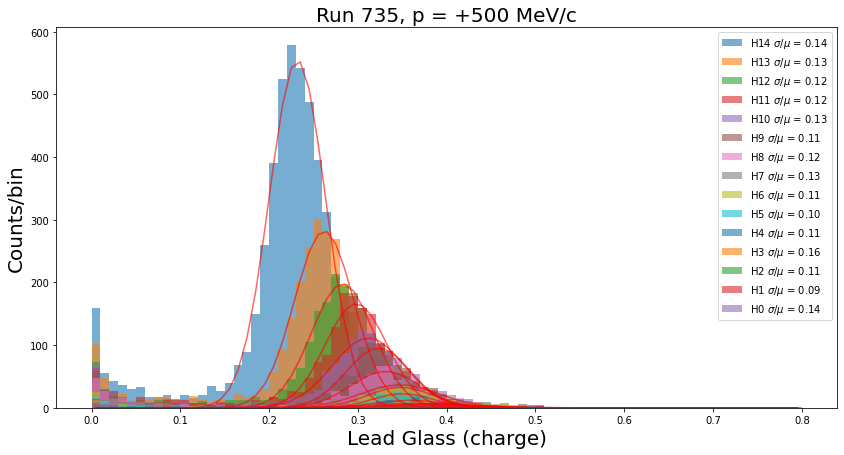

In [7]:
hd.gamma_peak_plot(final_df, 735, nbins=80, range=[0,0.8])

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all & (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_TOF0 = cuts_all & (final_df.hit_TOF0 == 1)
cuts_TOF1 = cuts_TOF0 & (final_df.hit_TOF1 == 1)
cuts_T2 = cuts_TOF1 & (final_df.hit_T2 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF0]['IntCharge'],bins=40,label="HD14+TOF0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF1]['IntCharge'],bins=40,label="HD14+TOF0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_T2]['IntCharge'],bins=40,label="HD14+TOF0/1/2")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
#plt.hist(df_dict['ACT3L'][df_dict['ACT3L']['PeakTime'] > 10]['PeakTime'],bins=100)
plt.hist(df_dict['ACT1L'][df_dict['ACT1L']['PeakTime'] > 10]['PeakTime'],bins=100)
#plt.hist(act0_combined['combined_charge'],bins=100)

In [ ]:
plt.hist(tof1_combined['combined_charge'],bins=100,range=[0,1])
#plt.hist(df_dict['TOF00']['PeakTime'],bins=100,range=[35,90])
#plt.hist(df_dict['TriggerScint']['IntCharge'],bins=100,range=[0,0.05])

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

## Single-peak analysis

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [ ]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [ ]:
df.head(100)

## Peak time analysis

In [ ]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

In [ ]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

In [ ]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);